In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/cubicasa5k.zip" -d "/content/cubicasa_dataset"

Streaming output truncated to the last 5000 lines.
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/F2_scaled.png  
  inflating:

In [4]:
!pip install opencv-python matplotlib lxml tqdm pycocotools


In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [6]:
!pip install torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [7]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ao1pfnq_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ao1pfnq_
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352521 sha256=e3255bc9ed2d26a1c682ec654dc88c06975d27341acb77ab98d065a1cc026131
  Stored in directory: /tmp/pip-ephem-wheel-cache-orqxz13b/wheels/d3/6e/bd/1969578f1456a6be2

In [42]:
import os
import json
from bs4 import BeautifulSoup

# 🗺️ Finnish → English room label translation
translation = {
    "OH": "Living Room", "MH": "Bedroom", "K": "Kitchen", "ET": "Entry",
    "KH": "Bathroom", "WC": "Toilet", "VH": "Walk-in Closet", "TK": "Utility Room",
    "KHH": "Utility Room", "PKH": "Dressing Room", "KHH/PKH": "Utility / Dressing Room",
    "PH": "Washing Room", "RT": "Dining Area", "TERASSI": "Terrace", "KUISTI": "Porch",
    "TEKN": "Technical Room", "VARASTO": "Storage", "SAUNA": "Sauna", "AULA": "Lobby",
    "TYÖHUONE": "Office", "RUOKAILU": "Dining Area", "PARVEKE": "Balcony",
    "ULKOTILA": "Outdoor Space", "KORKEA TILA": "High Ceiling Space", "H": "Room",
    "SpaceForAppliance2": "Appliance Space",
    "LASITETTU": "Glazed Balcony/Terrace", # Adding new translations
    "UNDEFINED": "Undefined", # Adding undefined label
    "PESUH": "Laundry Room",
    "PE": "Mirror/Cabinet", # Assuming this based on context
    "PESU": "Laundry/Washing Room",
    "LASI-PARV": "Glazed Balcony",
    "PSH": "Washing/Shower Room",
    "KK": "Kitchenette",
    "VAR/": "Storage",
    "HARRASTUS": "Hobby Room",
    "WC/KH": "Toilet/Bathroom",
    "KH/KHH": "Bathroom/Utility Room",
    "KATOS": "Shelter/Shed",
    "SH": "Shower Room",
    "KEITTIÖ": "Kitchen",
    "VAR": "Storage",
    "AUTOKATOS": "Carport",
    "AH": "Living Room/Lounge", # Assuming 'Aula/Hall' or similar
    "LIIKETILA": "Commercial Space",
    "ALKOVI": "Alcove",
    "SpaceForAppliance": "Appliance Space",
    "KATT.H": "Ceiling Height Room",
    "APUK": "Auxiliary Kitchen",
    "HARRASTETILA": "Hobby Space",
    "TH": "Fireplace/Technical Room",
    "TYÖH/VERSTAT": "Office/Workshop",
    "RUOK": "Dining",
    "AUTOTALLI": "Garage",
    "KPH": "Bathroom",
    "VAJA": "Shed",
    "LASIKUISTI": "Glazed Porch",
    "RP": "Fireplace",
    "KÄYTÄVÄ": "Corridor",
    "WC/PH": "Toilet/Washing Room",
    "KOM": "Closet/Storage",
    "WC-PH": "Toilet-Washing Room",
    "TYÖ- JA VIERASH": "Office and Guest Room",
    "ULLAKKO": "Attic",
    "KYLMÄ VARASTOTILA": "Cold Storage",
    "TEKN.TILA": "Technical Room",
    "AT": "Garage",
    "R": "Room", # Generic room
    "S": "Sauna",
    "AVOK": "Open Kitchen",
    "KYLMÄ VAR.": "Cold Storage",
    "RUOK.TILA": "Dining Area"

}

# 🏷️ Category map for COCO
# Start category IDs from 1 as per COCO format requirements for object detection
category_map = {name: i+1 for i, name in enumerate(sorted(set(translation.values())))}

def extract_svg_root(svg_path):
    with open(svg_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, "xml")
        return soup.find("svg")

def parse_polygon_bbox(polygon):
    points = polygon.get("points", "")
    coords = [tuple(map(float, p.split(","))) for p in points.strip().split()]
    xs, ys = zip(*coords)
    x, y, w, h = min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)
    return [x, y, w, h]

def parse_rooms(svg_root):
    rooms = []
    unmapped_labels = set() # Keep track of unmapped labels
    for g in svg_root.find_all("g", class_=lambda c: c and "Space" in c):
        polygon = g.find("polygon")
        if not polygon:
            continue

        label = None
        for sub in g.find_all("g", class_=lambda c: c and "NameLabel" in c):
            text_tag = sub.find("text")
            if text_tag and text_tag.text:
                label = text_tag.text.strip()
                break

        if not label:
            label = g.get("inkscape:label") or g.get("id")
            if label and "room-" in label:
                label = label.split("room-")[-1].strip()

        if not label:
            class_attr = g.get("class", "")
            label = class_attr.split()[-1]

        room_name = translation.get(label, label)

        if room_name not in category_map:
            unmapped_labels.add(room_name) # Add to unmapped set
            continue # Skip this room if not in category_map for now


        bbox = parse_polygon_bbox(polygon)

        rooms.append({
            "name": room_name,
            "bbox": bbox
        })
    if unmapped_labels:
        print(f"⚠️ Found unmapped labels: {unmapped_labels}") # Print unmapped labels
    return rooms


def generate_annotations(rooms, image_id, category_map, start_id=1):
    annotations = []
    for i, room in enumerate(rooms):
        name = room["name"]
        # Ensure category_id exists in category_map before assigning
        if name in category_map:
            category_id = category_map[name]
            area = room["bbox"][2] * room["bbox"][3]

            annotations.append({
                "id": start_id + i,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": room["bbox"],
                "area": area,
                "iscrowd": 0
            })
    return annotations

def process_svg_folder(folder_path, output_json):
    images = []
    annotations = []
    image_id = 1000
    ann_id = 1

    for filename in os.listdir(folder_path):
        if not filename.endswith(".svg"):
            continue

        svg_path = os.path.join(folder_path, filename)
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        images.append({
            "id": image_id,
            "file_name": filename,
            "width": 2048,  # optional: set actual width
            "height":2048
        })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": cid, "name": name} for name, cid in category_map.items()]
    }

    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f"✅ Saved {output_json} with {len(images)} images and {len(annotations)} annotations.")



In [43]:
svg_root = extract_svg_root("/content/cubicasa_dataset/cubicasa5k/colorful/10106/model.svg")
rooms = parse_rooms(svg_root)

for room in rooms:
    print(room)

{'name': 'Terrace', 'bbox': [394.41, 1553.54, 347.59999999999997, 341.20000000000005]}
{'name': 'Porch', 'bbox': [1144.01, 936.69, 151.51, 550.19]}
{'name': 'Terrace', 'bbox': [897.15, 181.74, 249.39999999999998, 302.15999999999997]}
{'name': 'Dining Area', 'bbox': [498.65, 212.96, 361.5, 307.93999999999994]}
{'name': 'Room', 'bbox': [498.65, 520.9, 610.9, 445.46000000000004]}
{'name': 'Kitchen', 'bbox': [133.66, 212.96, 364.99, 460.43999999999994]}
{'name': 'Entry', 'bbox': [440.65, 965.66, 354.59000000000003, 554.0300000000001]}
{'name': 'Room', 'bbox': [133.66, 978.66, 351.99, 541.0300000000001]}
{'name': 'Utility / Dressing Room', 'bbox': [808.24, 979.36, 301.30999999999995, 443.64]}
{'name': 'Room', 'bbox': [133.66, 686.4, 351.99, 279.26]}
{'name': 'Washing Room', 'bbox': [873.53, 1436.0, 229.92000000000007, 215.49]}
{'name': 'Toilet', 'bbox': [683.53, 1386.54, 177.0, 226.47000000000003]}
{'name': 'Undefined', 'bbox': [918.24, 1664.49, 191.30999999999995, 193.25]}
{'name': 'Techni

In [44]:
base_dir = "/content/cubicasa_dataset/cubicasa5k"

def load_split_folders(txt_path):
    """Loads folder paths from a .txt file."""
    paths = []
    with open(txt_path, 'r') as f:
        for line in f:
            # Remove leading/trailing whitespace and potential '/'
            cleaned_line = line.strip().strip('/')
            # The paths in the txt are already relative to the base_dir, so just use the cleaned line
            paths.append(cleaned_line)
    return paths

In [45]:
base_dir = "cubicasa_dataset/cubicasa5k"

def process_split(split_name, folder_paths, output_json):
    images, annotations = [], []
    image_id, ann_id = 1000, 1
    for relative_path in folder_paths:
        svg_path = os.path.join(base_dir, relative_path, "model.svg")
        png_path = os.path.join(base_dir, relative_path, "F1_scaled.png") # Path to the PNG image

        if not os.path.exists(svg_path):
            print(f"❌ model.svg not found at {svg_path}")
            continue
        if not os.path.exists(png_path): # Check if the corresponding PNG exists
             print(f"❌ F1_scaled.png not found at {png_path}")
             continue

        # Get image dimensions
        try:
            with Image.open(png_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"❌ Could not read image size for {png_path}: {e}")
            continue

        # Only process if both files exist and dimensions are read
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        style = relative_path.split("/")[0]  # e.g., "colorful"
        folder_name = relative_path.split("/")[1]  # e.g., "10052"

        images.append({
           "id": image_id,
           "file_name": png_path, # Use the PNG path here
           "style": style,
           "width": width,  # Use actual width
           "height": height # Use actual height
         })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": cid, "name": name} for name, cid in category_map.items()]
    }

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f"✅ Saved {split_name} annotations to {output_json}")

In [46]:
from PIL import Image
import os

train_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/train.txt"))
val_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/val.txt"))
test_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/test.txt"))

process_split("train", train_folders, "annotations/train_annotations.json")
process_split("val", val_folders, "annotations/val_annotations.json")
process_split("test", test_folders, "annotations/test_annotations.json")

⚠️ Found unmapped labels: {'TUPA'}
⚠️ Found unmapped labels: {'TUPAKEITTIÖ', 'PARVI'}
⚠️ Found unmapped labels: {'KHH/WC/SH'}
⚠️ Found unmapped labels: {'TK/KUISTI', 'OLESKELU', 'RAKENTAMATONTILA', 'TYÖH', 'PUKUH', 'YLÄAULA'}
⚠️ Found unmapped labels: {'VINTTI', 'TUPA'}
⚠️ Found unmapped labels: {'VARASTO/', 'VAR/TEKN', 'PUKU', 'KELLARI', 'VILPOLA'}
⚠️ Found unmapped labels: {'PUKUH', 'HALLI'}
⚠️ Found unmapped labels: {'PUKUH'}
⚠️ Found unmapped labels: {'VERANTA'}
⚠️ Found unmapped labels: {'TUPAK'}
⚠️ Found unmapped labels: {'KAMARI', 'TUPA'}
⚠️ Found unmapped labels: {'ASK'}
⚠️ Found unmapped labels: {'ÖLJY'}
⚠️ Found unmapped labels: {'TYÖH'}
⚠️ Found unmapped labels: {'KPH/KHH', 'OH+K+RUOK'}
⚠️ Found unmapped labels: {'AUTOVAJA'}
⚠️ Found unmapped labels: {'K+R', 'KHH/KPH'}
⚠️ Found unmapped labels: {'KHT'}
⚠️ Found unmapped labels: {'LASITETTU PARVEKE'}
⚠️ Found unmapped labels: {'LASITETTU PARVEKE'}
⚠️ Found unmapped labels: {'AUTOSUOJA', 'K+APUK'}
⚠️ Found unmapped labels: {'P

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90344064 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Found unmapped labels: {'PH/KHH', 'WC/TEKN'}
⚠️ Found unmapped labels: {'KH/WC'}
⚠️ Found unmapped labels: {'LH'}
⚠️ Found unmapped labels: {'VAR.TEKN'}
⚠️ Found unmapped labels: {'OH/RUOK', 'KIRJASTO/TH'}
⚠️ Found unmapped labels: {'PH/WC'}
⚠️ Found unmapped labels: {'VIHERH'}
⚠️ Found unmapped labels: {'KH/WC'}
⚠️ Found unmapped labels: {'K+R', 'LASITETTU TERASSI'}
⚠️ Found unmapped labels: {'TYÖH'}
⚠️ Found unmapped labels: {'KYLMÄ'}
⚠️ Found unmapped labels: {'OLESKELU', 'MH/KIRJASTO'}
⚠️ Found unmapped labels: {'TYÖH', 'MTH'}
⚠️ Found unmapped labels: {'PH/WC'}
⚠️ Found unmapped labels: {'WC/S'}
⚠️ Found unmapped labels: {'KHH/PUKUH', 'KIRJASTO', 'TORNI'}
⚠️ Found unmapped labels: {'VAR (LÄMMIN)'}
⚠️ Found unmapped labels: {'PUUVAR', 'ÖLJY', 'KATTILAH'}
⚠️ Found unmapped labels: {'TUPA'}
⚠️ Found unmapped labels: {'PIHA'}
⚠️ Found unmapped labels: {'AUTOVAJA'}
⚠️ Found unmapped labels: {'TUPAK'}
⚠️ Found unmapped labels: {'ET/AULA'}
⚠️ Found unmapped labels: {'KHH/PUKUH', 'TYÖH

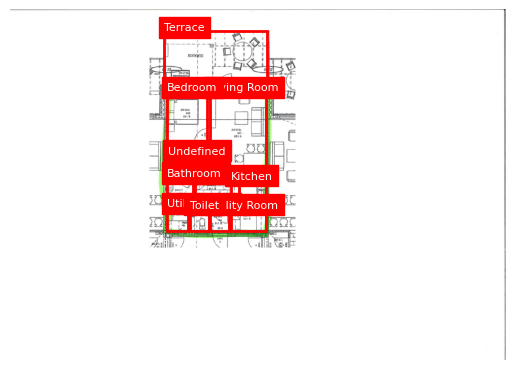

In [47]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load annotations
with open("annotations/train_annotations.json") as f:
    coco = json.load(f)

# Build image lookup
image_lookup = {img["id"]: img for img in coco["images"]}
category_lookup = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Visualize one image
def visualize_image(image_id, base_dir):
    img_info = image_lookup[image_id]
    # Construct the full image path correctly using os.path.join
    img_path = os.path.join("/content/", img_info["file_name"])

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found: {img_path}")
        return

    image = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for ann in coco["annotations"]:
        if ann["image_id"] != image_id:
            continue
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label = category_lookup.get(ann["category_id"], "Unknown")
        ax.text(x, y - 5, label, color='white', fontsize=8, backgroundcolor='red')

    plt.axis('off')
    plt.show()

# Example usage
# Use a valid image_id from your dataset (e.g., the first one)
if coco["images"]:
    first_image_id = coco["images"][0]["id"]
    visualize_image(first_image_id, "/content/cubicasa_dataset/cubicasa5k")
else:
    print("No images found in the annotations.")

In [54]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Paths to your annotation files
register_coco_instances("cubicasa_train", {}, "annotations/train_annotations.json", "")
register_coco_instances("cubicasa_val", {}, "annotations/val_annotations.json", "")
register_coco_instances("cubicasa_test", {}, "annotations/test_annotations.json", "")

In [55]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))


In [65]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cc

cfg.DATASETS.TRAIN = ("cubicasa_train",)
cfg.DATASETS.TEST = ("cubicasa_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.OUTPUT_DIR = "/content/drive/MyDrive/cubicasa_checkpoints"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []  # No LR decay
cfg.SOLVER.CHECKPOINT_PERIOD = 100  # Save every 1000 iterations

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_map)  # Your room types


trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/10 17:11:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/10 17:25:18 d2.utils.events]:  eta: 2:04:47  iter: 319  total_loss: 2.157  loss_cls: 1.066  loss_box_reg: 0.8813  loss_rpn_cls: 0.1001  loss_rpn_loc: 0.07785    time: 41.2212  last_time: 42.4400  data_time: 0.0609  last_data_time: 0.0068   lr: 0.00015959  
[09/10 17:39:40 d2.utils.events]:  eta: 1:50:17  iter: 339  total_loss: 2.051  loss_cls: 1.017  loss_box_reg: 0.8533  loss_rpn_cls: 0.07878  loss_rpn_loc: 0.05804    time: 41.8346  last_time: 45.1161  data_time: 0.0094  last_data_time: 0.0047   lr: 0.00016958  
[09/10 17:54:33 d2.utils.events]:  eta: 1:38:19  iter: 359  total_loss: 2.091  loss_cls: 1.06  loss_box_reg: 0.8303  loss_rpn_cls: 0.07204  loss_rpn_loc: 0.06713    time: 42.8039  last_time: 42.7732  data_time: 0.0108  last_data_time: 0.0097   lr: 0.00017957  
[09/10 18:09:46 d2.utils.events]:  eta: 1:25:23  iter: 379  total_loss: 2.04  loss_cls: 1.007  loss_box_reg: 0.8118  loss_rpn_cls: 0.1065  loss_rpn_loc: 0.07439    time: 43.5279  last_time: 46.3833  data_time: 0.0096

[09/10 19:44:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/cubicasa_checkpoints/model_final.pth ...


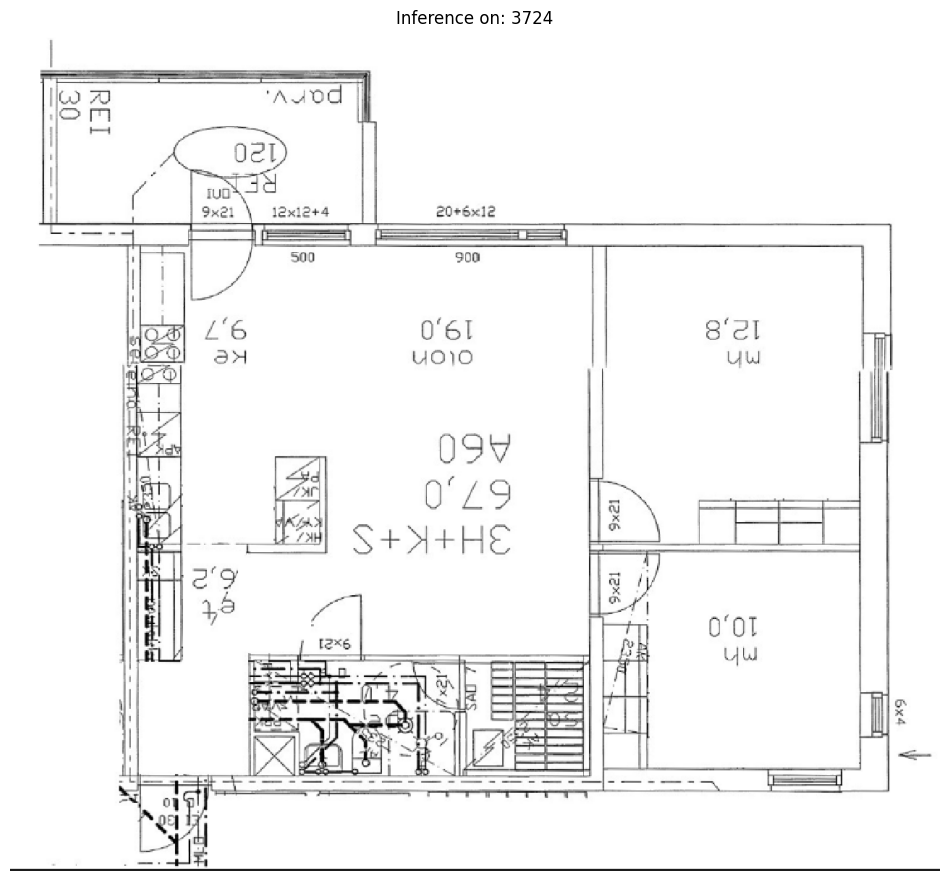

In [76]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2, os, random
import matplotlib.pyplot as plt

# Load trained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/cubicasa_checkpoints/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_map)
cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)

# Pick a random image
base_dir = "/content/cubicasa_dataset/cubicasa5k/high_quality_architectural/"
folder = random.choice(os.listdir(base_dir))
image_path = os.path.join(base_dir, folder, "F1_scaled.png")
image = cv2.imread(image_path)

# Run inference
outputs = predictor(image)

# Visualize
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get("cubicasa_val"), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12, 12))
plt.imshow(out.get_image())
plt.axis("off")
plt.title(f"Inference on: {folder}")
plt.show()

In [53]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Unregister the datasets if they exist
if "cubicasa_train" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_train")

if "cubicasa_train" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_train")

if "cubicasa_test" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_test")

if "cubicasa_test" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_test")

if "cubicasa_val" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_val")

if "cubicasa_val" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_val")
